# Install Dependencies

The SciPy library is needed for the distance transform  to run.



In [0]:
!pip install scipy
!pip install torchvision  
!pip install --no-cache-dir -I pillow

#!curl https://colab.chainer.org/install | sh -

     |████████████████████████████████| 2.0MB 4.9MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


# Setup the Running Drive Folder



In [0]:
# Load the Drive helper and mount
from google.colab import drive

# Mount the drive folder. This will prompt for authorization.
drive.mount('/content/drive', force_remount=True)


# Opens the project folder. IMPORTANT: Change to your route
%cd 'drive/My Drive/Parma/Tracking/'

Mounted at /content/drive
/content/drive/My Drive/Parma/Tracking


# Modules Importation

In [0]:
import sys
import os
import numpy as np
#import cupy as cp
import random
import time
import math
import csv
from PIL import Image
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch import argmax
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataset import ConcatDataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms.functional as Ft
from torch.autograd.variable import Variable

from scipy.ndimage.morphology import distance_transform_edt as dist_trans

# Misc Functions

In [0]:
""" 
    Export data to csv format. Creates new file if doesn't exist,
    otherwise update it.
    Args:
        header (list): headers of the column
        value (list): values of correspoding column
        folder: folder path
        file_name: file name with path
"""
def export_history(header, value, folder, file_name):
    # If folder does not exists make folder
    if not os.path.exists(folder):
        os.makedirs(folder)

    file_path = folder + file_name
    file_existence = os.path.isfile(file_path)

    # If there is no file make file
    if file_existence == False:
        file = open(file_path, 'w', newline='')
        writer = csv.writer(file)
        writer.writerow(header)
        writer.writerow(value)
    # If there is file overwrite
    else:
        file = open(file_path, 'a', newline='')
        writer = csv.writer(file)
        writer.writerow(value)
    # Close file when it is done with writing
    file.close()


""" 
    Save the state of a net.
"""
def save_checkpoint(state, path='checkpoint/', filename='weights.pth'):
    # If folder does not exists make folder
    if not os.path.exists(path):
        os.makedirs(path)

    filepath = os.path.join(path, filename)
    torch.save(state, filepath)


""" 
    Computes and stores the average and current value
    Imported from https://github.com/pytorch/examples/blob/master/imagenet/main.py#L247-L262
"""  
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Definition of the Architecture

As we show in the above image, U-Net consists on a big amounts of layers. In the following 2 cells all the parts of U-Net will be implemented. Each part have its own comment.

In [0]:
""" 
    This file defines every layer (or group of layers) that are inside UNet.
    At the final the architecture UNet is defined as a conjuntion of the elements created.
"""
class double_conv(nn.Module):
    ''' Applies (conv => BN => ReLU) two times. '''

    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=(1,1)),
            nn.BatchNorm2d(out_ch),
            # inplace is for aply ReLU to the original place, saving memory
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=(1,1)),
            nn.BatchNorm2d(out_ch),
            # inplace is for aply ReLU to the original place, saving memory
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    ''' First Section of U-Net. '''

    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    ''' Applies a MaxPool with a Kernel of 2x2,
        then applies a double convolution pack. '''

    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()

        self.mpconv = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, padding=(1,1), dilation=(1,1)),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    ''' Applies a Deconvolution and then applies applies a double convolution pack. '''

    def __init__(self, in_ch, out_ch, bilinear=False):
        super(up, self).__init__()
        
        # Bilinear is used to save computational cost
        if bilinear:
            self.up = nn.Upsample(
                scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(
                in_ch//2, in_ch//2, kernel_size=3, stride=2, padding=(1,1))

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffX = x1.size()[2] - x2.size()[2]
        diffY = x1.size()[3] - x2.size()[3]
        x2 = F.pad(input=x2, pad=(diffX // 2, diffX // 2,
                                  diffY // 2, diffY // 2))
        
        print(x1.shape)
        print(x2.shape)
        
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    ''' Applies the last Convolution to give an answer. '''

    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()

        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=1)

    def forward(self, x):
        x = self.conv(x)
        return x

      

In [0]:
class UNet(nn.Module):
    ''' This Object defines the architecture of U-Net. '''

    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        
        """
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)
        """
        
        self.inc = inconv(n_channels, 16)
        self.down1 = down(16, 32)
        self.down2 = down(32, 64)
        self.down3 = down(64, 128)
        self.down4 = down(128, 128)
        self.up1 = up(256, 64)
        self.up2 = up(128, 32)
        self.up3 = up(64, 16)
        self.up4 = up(32, 16)
        self.outc = outconv(16, n_classes)
        
        
        
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        #x = F.softmax(x) # New softmax layer
        return x

# Functions for Loading the Data

The nexts cells are there for the loading process. In this case we use the Dataset and Dataloader objects given by Pytorch. In the training process we will call this section

In [0]:
'''
    Class that defines the reading and processing of the images.
    Specialized on BBBC006 dataset.
'''
class ImageDataset(Dataset):
    def __init__(self, ids, dir_data, dir_gt, extension='.png'):

        self.dir_data = dir_data
        self.dir_gt = dir_gt
        self.extension = extension

        # Transforms
        self.data_transforms = {
            'imgs': transforms.Compose([
#                 transforms.RandomResizedCrop(256),
#                 transforms.RandomHorizontalFlip(),
#                transforms.Resize((256, 256)),
                transforms.ToTensor(),
                #transforms.Normalize([0.0054],[0.0037])
            ]),
            'masks': transforms.Compose([
#                transforms.Resize((256, 256)),
                transforms.ToTensor()
            ]),
        }

        # Images IDS
        self.ids = ids

        # Calculate len of data
        self.data_len = len(self.ids)

    '''
        Ask for an image.
    '''
    def __getitem__(self, index):
      
        # Get an ID of a specific image
        id_img = self.dir_data + self.ids[index] + self.extension
        id_gt = self.dir_gt + self.ids[index] + self.extension
        # Open Image and GroundTruth
        img = Image.open(id_img)#.convert('L')
        gt = Image.open(id_gt).convert('L')
        # Applies transformations
        img = self.data_transforms['imgs'](img)
        gt = self.data_transforms['masks'](gt)
        
        return (img, gt.float())

    '''
        Length of the dataset.
        It's needed for the upper class.
    '''
    def __len__(self):
        return self.data_len


In [0]:
'''
    Class that defines the reading and processing of the images.
    Specialized on BBBC006 dataset.
'''
class ImageDataset_Transform(Dataset):
    def __init__(self, ids, dir_data, extension='.png'):

        self.dir_data = dir_data
        self.extension = extension

        # Transforms
        self.data_transforms = {
            'imgs': transforms.Compose([
#                 transforms.RandomResizedCrop(256),
#                 transforms.RandomHorizontalFlip(),
                transforms.Resize((256, 256)),
                transforms.ToTensor(),
                transforms.Normalize([0.0054],[0.0037])
            ]),
            'masks': transforms.Compose([
                transforms.Resize((256, 256)),
                transforms.ToTensor()
            ]),
        }

        # Images IDS
        self.ids = ids

        # Calculate len of data
        self.data_len = len(self.ids)

    '''
        Ask for an image.
    '''
    def __getitem__(self, index):
        # Get an ID of a specific image
        id_img = self.dir_data + self.ids[index] + self.extension
        # Open Image and GroundTruth
        img = Image.open(id_img)#.convert('L')
        # Applies transformations
        img = self.data_transforms['imgs'](img)
        return (img, self.ids[index]+self.extension)

    '''
        Length of the dataset.
        It's needed for the upper class.
    '''
    def __len__(self):
        return self.data_len

In [0]:
'''
    Returns the dataset separated in batches.
    Used inside every epoch for retrieving the images.
'''
def get_dataloaders(dir_img, dir_gt, test_percent=0.2, batch_size=10):
  
    # Validate a correct percentage
    test_percent = test_percent/100 if test_percent > 1 else test_percent
    # Read the names of the images
    ids = [f[:-4] for f in os.listdir(dir_img)]
    # Creates the dataset
    dset = ImageDataset(ids, dir_img, dir_gt)
    
    # Calculate separation index for training and validation
    num_train = len(dset)
    indices = list(range(num_train))
    split = int(np.floor(test_percent * num_train))
    np.random.shuffle(indices)
    train_idx, valid_idx = indices[split:], indices[:split]

    # Create the dataloaders
    dataloaders = {}
    dataloaders['train'] = DataLoader(dset, batch_size=batch_size,
                                               sampler=SubsetRandomSampler(train_idx))
    dataloaders['val'] = DataLoader(dset, batch_size=batch_size,
                                                   sampler=SubsetRandomSampler(valid_idx))
   
    return dataloaders['train'], dataloaders['val']

In [0]:
'''
    Returns whole dataset to transform.
'''
def get_dataloader_transform(dir_img, batch_size = 1):
    # Read the names of the images
    ids = [f[:-4] for f in os.listdir(dir_img)]
    # Creates the dataset
    dset = BBBCDataset_Transform(ids, dir_img)

    # Create the dataloader
    dataloader = DataLoader(dset, batch_size=batch_size)

    return dataloader

# Training the Model

The next 3 cells are for training the model. Each part is commented.

In [0]:
""" 
    Class that defines the Dice Loss function.
"""
class DiceLoss(nn.Module):
  
    def __init__(self, smooth = 1):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def dice_coef(self, y_pred, y_true):
        pred_probs = torch.sigmoid(y_pred)
        y_true_f = y_true.view(-1)
        y_pred_f = pred_probs.view(-1)
        intersection = torch.sum(y_true_f * y_pred_f)
        return (2. * intersection + self.smooth) / (torch.sum(y_true_f) + torch.sum(y_pred_f) + self.smooth)
  
    def forward(self, y_pred, y_true):
        return -self.dice_coef(y_pred, y_true)
    
""" 
    Class that defines the Root Mean Square Loss function.
"""
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))
      
      
"""
    Class that defines the Cross Entropy Loss Function
"""
class CELoss(nn.Module):
    def __init__(self):
        super(CELoss, self).__init__()

    def forward(self, y_pred, y_true):
        return -torch.mean(torch.sum(y_true*torch.log(F.softmax(y_pred,dim=1)),dim=1))

In [0]:
""" 
    Functions that trains a net.
"""
def train_net(net, device, loader, optimizer, criterion, batch_size, loss_type):
    net.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    time_start = time.time()
    for batch_idx, (data, gt) in enumerate(loader):

        # Use GPU or not
        data, gt = data.to(device), gt.to(device)

        # Forward
        predictions = net(data)
        
        # Loss Calculation
        if loss_type == "Cross":
            labels = argmax(gt, dim=1)
            loss = criterion(predictions, labels)
        else:
            loss = criterion(predictions, gt)
            
        # Updates the record
        train_loss.update(loss.item(), predictions.size(0))
        train_acc.update(-loss.item(), predictions.size(0))
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # Does clipping of the gradient to avoid exploding gradient
        if loss_type == "Grad" or loss_type == "Custom_Grad":
          nn.utils.clip_grad_norm(net.parameters(), clip)

        # Calculates new parameters
        optimizer.step()

        print('[{}/{} ({:.0f}%)]\t\tLoss: {:.6f}'.format(
            batch_idx * len(data), len(loader)*batch_size,
            100. * batch_idx / len(loader), loss.item()))

    time_dif = time.time() - time_start
    print('\nAverage Training Loss: ' + str(train_loss.avg))
    print('\nAverage Training Accuracy: ' + str(train_acc.avg))
    print('Train Time: It tooks %.4fs to finish the epoch.' % (time_dif))
            
    return train_loss.avg, train_acc.avg

In [0]:
""" 
    Function that validates the net.
"""
def val_net(net, device, loader, criterion, batch_size):
    net.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    time_start = time.time()
    with torch.no_grad():
        for batch_idx, (data, gt) in enumerate(loader):

            # Use GPU or not
            data, gt = data.to(device), gt.to(device)

            # Forward
            predictions = net(data)
            
            # Loss Calculation
            loss = criterion(predictions, gt)

            # Updates the record
            val_loss.update(loss.item(), predictions.size(0))
            val_acc.update(-loss.item(), predictions.size(0))
            
            print('[{}/{} ({:.0f}%)]\t\tLoss: {:.6f}'.format(
                batch_idx * len(data), len(loader)*batch_size,
                100. * batch_idx / len(loader), loss.item()))
    
    time_dif = time.time() - time_start
    print('\nValidation set: Average loss: '+ str(val_loss.avg))
    print('\nAverage Validation Accuracy: ' + str(val_acc.avg))
    print('Validation time: It tooks %.4fs to finish the Validation.' % (time_dif))
    
    return val_loss.avg, val_acc.avg

In [0]:
'''
    Configure every aspect of the run.
    Runs the training and validation.
'''
def setup_and_run_train(n_channels, n_classes, dir_img, dir_gt, dir_results, load, 
                val_perc, batch_size, epochs, lr, run, optimizer, loss, loaders):
    
    # Use GPU or not
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # Create the model
    net = UNet(n_channels, n_classes).to(device)
    net = torch.nn.DataParallel(net, device_ids=list(
        range(torch.cuda.device_count()))).to(device)

    # Load old weights
    if load:
        net.load_state_dict(torch.load(load)['state_dict'])
        print('Model loaded from {}'.format(load))

    if loaders:
      train_loader, val_loader = loaders[0], loaders[1]
      train_size = "Fixed"
      loader_size = "Fixed"
      
    else:
      
      train_loader, val_loader = get_dataloaders(dir_img, dir_gt, val_perc, batch_size)
            
      train_size = len(train_loader)*batch_size
      loader_size = len(val_loader)*batch_size
            
    # Pretty print of the run
    print('''\n
    Starting training:
        Dataset: {}
        Num Channels: {}
        Groundtruth: {}
        Num Classes: {}
        Folder to save: {}
        Load previous: {}
        Training size: {}
        Validation size: {}
        Batch size: {}
        Epochs: {}
        Learning rate: {}
        Optimizer: {}
        Loss Function: {}
        CUDA: {}
    '''.format(dir_img, n_channels, dir_gt, n_classes, dir_results, load, 
            train_size, loader_size, batch_size, epochs, lr, optimizer, loss, use_cuda))

    # Definition of the optimizer ADD MORE IF YOU WANT
    if optimizer == "Adam":
        optimizer = torch.optim.Adam(net.parameters(),
                             lr=lr)
    elif optimizer == "SGD":
        optimizer = torch.optim.SGD(net.parameters(),
                        lr=lr,
                        momentum=0.9,
                        weight_decay=0.0005)

    # Definition of the loss function ADD MORE IF YOU WANT
    if loss == "Dice":
        criterion = DiceLoss()
    elif loss == "RMSE":
        criterion = RMSELoss()
    elif loss == "MSE":
        criterion = nn.MSELoss()
    elif loss == "MAE":
        criterion = nn.L1Loss()
    elif loss == "CE":
        criterion = CELoss()
    elif loss == "Cross":
        weights = torch.tensor([0.5, 1.0, 2.0])
        weights = weights.to(device)
        
        criterion = nn.CrossEntropyLoss(weights)
    

    # Saving History to csv
    header = ['epoch', 'train loss', 'validation loss']

    best_loss = 10000
    time_start = time.time()
    # Run the training and validation
    for epoch in range(epochs):
        print('\nStarting epoch {}/{}.'.format(epoch + 1, epochs))

        train_loss, train_acc = train_net(net, device, train_loader, optimizer, criterion, batch_size, loss)
        val_loss, val_acc = val_net(net, device, val_loader, criterion, batch_size)
        
        values = [epoch+1, train_loss, val_loss]
        export_history(header, values, dir_results, "result"+str(run)+".csv")
        
        # save model
        if val_loss < best_loss:
            best_loss = val_loss
            save_checkpoint({
                    'epoch': epoch + 1,
                    'state_dict': net.state_dict(),
                    'loss': train_loss,
                    'optimizer' : optimizer.state_dict(),
                }, path=dir_results, filename="weights"+str(run)+".pth")

    time_dif = time.time() - time_start
    print("It tooks %.4f seconds to finish the run." % (time_dif))
    
    return train_loss, val_loss

# Running the Training

Now, we will run the training. You can change this hyperparameters to see how affects the results.

**Only one run**

## Back Model

In [0]:
setup_and_run_train(n_channels = 3, 
                    n_classes = 1, 
                    dir_img = 'Datasets/Images/SenDF/Real/', 
                    dir_gt = 'Datasets/Images/SenDF/GT_DT/', 
                    dir_results = 'checkpoints/DT/', 
                    #load = 'checkpoints/DT/weights1.pth', 
                    load = False,
                    val_perc = 20, 
                    batch_size = 10, 
                    epochs = 10, 
                    lr = 0.001, 
                    run = str(1), 
                    optimizer = "Adam", 
                    loss = "MSE", 
                    loaders = False)



    Starting training:
        Dataset: Datasets/Images/SenDF/Real/
        Num Channels: 3
        Groundtruth: Datasets/Images/SenDF/GT_DT/
        Num Classes: 1
        Folder to save: checkpoints/DT/
        Load previous: False
        Training size: 1340
        Validation size: 340
        Batch size: 10
        Epochs: 10
        Learning rate: 0.001
        Optimizer: Adam
        Loss Function: MSE
        CUDA: True
    

Starting epoch 1/10.
torch.Size([10, 128, 63, 83])
torch.Size([10, 128, 63, 83])
torch.Size([10, 64, 125, 165])
torch.Size([10, 64, 124, 164])


RuntimeError: ignored

## Top Model

In [0]:
setup_and_run_train(n_channels = 1, 
                    n_classes = 3, 
                    dir_img = 'predictions/DT/',
                    dir_img_2 = None,
                    dir_gt = 'data/Border/', 
                    dir_results = 'checkpoints/Border/', 
                    load = False, 
                    val_perc = 0, 
                    batch_size = 10, 
                    epochs = 25,
                    lr = 0.001, 
                    run = str(1), 
                    optimizer = "Adam", 
                    loss = "CE", 
                    loaders = False)

# Several runs - With K-Folds Cross Validations

In [0]:
# Defines a function to obtain k loaders for k fold cross validation
def get_predloader_k_folds(k, dir_img, dir_img_2, dir_gt, batch_size=1):
    
    # Read the names of the images
    ids = [f[:-4] for f in os.listdir(dir_img)]
    # Rearrange the images
    #random.shuffle(ids)
    # Obtains total of images
    total = len(ids)
    
    # Sets the actual id
    id_actual = 0
    
    # Sets the amount of ids to use in each loader
    partition = total // k
    
    loaders = []
    
    for i in range(0, k):
      
      # Calculate index of partition
      ids_pred = ids[id_actual:id_actual+partition]

      # Create the datasets
      if dir_img_2 != None:
        loaders.append(BBBCDataset_2_inputs(ids=ids_pred, dir_data_1=dir_img, dir_data_2=dir_img_2, dir_gt=dir_gt))
      else:
        loaders.append(BBBCDataset(ids=ids_pred, dir_data=dir_img, dir_gt=dir_gt))
      
      # Recalculate actual id
      id_actual += partition

    return loaders

In [0]:
def K_Folds_Validation(k, epoch_inicial, iteracion_inicial, batch_size, dir_img, dir_img_2, dir_gt, dir_predictions, dir_results):

  # Sets values to obtain the accumulate of the training and validation loss
  acum_train = 0
  acum_test = 0
  
  # Obtain the loaders for validation
  datasets = get_predloader_k_folds(k, dir_img, dir_img_2, dir_gt, batch_size=10)

  for i in range(iteracion_inicial, k):
    
    # Builds the dataloader for validation with the i-th dataset
    val_loader = DataLoader(datasets[i], batch_size=10, shuffle=True)
    
    train_data = []
    
    for j in range(0, k):
      if j != i:
        train_data.append(datasets[j])
    
    # Builds the dataloader for training with the remaining datasets
    train_loader = DataLoader(ConcatDataset(train_data), batch_size=10, shuffle=True)
    
    # Builds the loader with the training and validation sets
    loaders = [train_loader, val_loader]     
    
    if epoch_inicial != 0:
      
      # Runs the training from a certain point in time
      train_loss, test_loss = setup_and_run_train(n_channels = 1, 
                                                n_classes = 1, 
                                                dir_img = dir_img,
                                                dir_img_2 = dir_img_2,
                                                dir_gt = dir_gt, 
                                                dir_results = dir_results, 
                                                load = dir_results+"weights"+str(i)+".pth", 
                                                val_perc = 0, 
                                                batch_size = 10, 
                                                epochs = 50 - epoch_inicial,
                                                lr = 0.001, 
                                                run = i, 
                                                optimizer = "Adam", 
                                                loss = "MAE", 
                                                loaders = loaders)
      epoch_inicial = 0
      
    else:
      # Runs the training
      train_loss, test_loss = setup_and_run_train(n_channels = 1, 
                                                  n_classes = 1, 
                                                  dir_img = dir_img,
                                                  dir_img_2 = dir_img_2,
                                                  dir_gt = dir_gt, 
                                                  dir_results = dir_results, 
                                                  load = None, 
                                                  val_perc = 0, 
                                                  batch_size = 10, 
                                                  epochs = 50,
                                                  lr = 0.001, 
                                                  run = i, 
                                                  optimizer = "Adam", 
                                                  loss = "MAE", 
                                                  loaders = loaders)
    
    print("Termino el entrenamiento \n")
    
    if not os.path.isdir(dir_predictions+"run_"+str(i)+"/"):
      os.mkdir(dir_predictions+"run_"+str(i)+"/")
      
    save_dataset(dir_predictions+"run_"+str(i)+"/", dir_results+"weights"+str(i)+".pth", 1, dir_img, 'L', None)
    
    acum_train += train_loss
    acum_test += test_loss

  acum_train /= k
  acum_test /= k
  
  print("\nEl error final en training promediado ha sido de: " + str(acum_train))
  print("\nEl error final en validacion promediado ha sido de: " + str(acum_val))


In [0]:
K_Folds_Validation(k=5, 
                   epoch_inicial= 0, 
                   iteracion_inicial = 3, 
                   batch_size=10, 
                   dir_img='data/Original/', 
                   dir_img_2=None, 
                   dir_gt='data/Distance_Transform/',
                   dir_predictions = "predictions/DT/K-Folds/",
                   dir_results = 'checkpoints/DT/K-Folds/')

In [0]:
!ls predictions/Border/

# Image from tensor

In [0]:
def to_image(tensor, nrow=8, padding=2,
               normalize=False, range=None, scale_each=False, pad_value=0):
    """Save a given Tensor into an image file.

    Args:
        tensor (Tensor or list): Image to be saved. If given a mini-batch tensor,
            saves the tensor as a grid of images by calling ``make_grid``.
        **kwargs: Other arguments are documented in ``make_grid``.
    """
    from PIL import Image
    tensor = tensor.cpu()
    grid = make_grid(tensor, nrow=nrow, padding=padding, pad_value=pad_value,
                     normalize=normalize, range=range, scale_each=scale_each)
    ndarr = grid.mul(255).clamp(0, 255).byte().permute(1, 2, 0).numpy()
    im = Image.fromarray(ndarr)
    return im

# Function to create a new Dataset

This script is made to iterate over a directory applying a given set of weigths while saving the output to be made or used as a new dataset

In [0]:
def save_dataset(dir_save, load, n_classes, dir_img, conversion, out):
  with torch.no_grad():
        
        loader = get_dataloader_transform(dir_img)
        
        # Use GPU or not
        use_cuda = torch.cuda.is_available()
        device = torch.device("cuda" if use_cuda else "cpu")

        # Create the model - 256 classes are used so the resulting image can better reflect the grayscale groundtruth
        #net = UNet(n_channels=1, n_classes=1).to(device)
        # Create the model
        net = UNet(n_channels=1, n_classes= n_classes).to(device)
        net = torch.nn.DataParallel(net, device_ids=list(
            range(torch.cuda.device_count()))).to(device)

        # Load old weights
        if load:
            net.load_state_dict(torch.load(load)["state_dict"])
            print('Model loaded from {}'.format(load))
            
        net.eval()
        
        for batch_idx, (data, id_n) in enumerate(loader):
        
   
            # Use GPU or not
            data = data.to(device, dtype=torch.float)
            
            # Forward
            predictions = net(data)
            
            if out == "Softmax":
              predictions = F.softmax(predictions)
            
            # Saves the image
            img = to_image(predictions)
            img_new = img.convert(conversion)
            img_new.save(dir_save + id_n[0])


# Test for folder existance

This cmd line tests if the folder exists and if colab can reach to it

In [0]:
!ls predictions/DT/MAE_BDE_N/

Test  Train


# Create Dataset for Back Model predictions

# Save Train Dataset

In [0]:
save_dataset(dir_save='predictions/DT/K-Folds/run_4/', 
             load='checkpoints/DT/K-Folds/weights4.pth', 
             n_classes=1, 
             dir_img='data/Original/',
             conversion='L',
             out = None)

Model loaded from checkpoints/DT/K-Folds/weights4.pth


KeyboardInterrupt: ignored

# Save Test Dataset

In [0]:
save_dataset(dir_save='predictions/DT/MAE_BDE_N/Test/', 
             load='checkpoints/DT/weights1.pth', 
             n_classes=1, 
             dir_img='data/Original/Test/',
             conversion='L',
             out = None)

Model loaded from checkpoints/DT/weights1.pth


# Create Dataset for Top Model predictions

# Save Train Dataset

In [0]:
save_dataset(dir_save='predictions/Border/Prueba/run_0/', 
             load='checkpoints/Border/K-Folds/weights0.pth', 
             n_classes=3, 
             dir_img='data/Original/',
             conversion='RGB',
             out=None)

Model loaded from checkpoints/Border/K-Folds/weights0.pth


# Save Test Dataset

In [0]:
save_dataset(dir_save='predictions/Border_Idea/Test/', 
             load='checkpoints/Border_Idea/weights1.pth', 
             n_classes=3, 
             dir_img='predictions/DT/MAE_BDE_N/Test/',
             conversion='RGB',
             out=None)

Model loaded from checkpoints/Border_Idea/weights1.pth


# Seeing the results

In the following charts it's the code that uses the trained model and predict some samples.

In [0]:
def predict_imgs(net, device, loader, criterion, show=False, post=None):
    
    #net.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    
    i = 1
    
    with torch.no_grad():
        for batch_idx, (data, gt) in enumerate(loader):
   
            # Use GPU or not
            data, gt = data.to(device, dtype=torch.float), gt.to(device, dtype=torch.float)
            
            fig=plt.figure(figsize=(40, 40))
            
            if show:
              
                # Shows original image
                data_img = transforms.ToPILImage()(data.squeeze(0).cpu()).convert('RGB')
                fig=plt.figure(figsize=(40, 40))
                fig.add_subplot(1, 4, 1)
                plt.imshow(data_img)
            
            # Forward
            predictions = net(data)
            
            if post == "Softmax":
              predictions = F.softmax(predictions)
            
            #save_image(predictions, 'results/pred_' + str(i) + '.png')
            #save_image(gt, 'results/gt_' + str(i) + '.png')
            
            # Loss Calculation
            loss = criterion(predictions, gt)

            # Updates the record
            val_loss.update(loss.item(), predictions.size(0))
            val_acc.update(-loss.item(), predictions.size(0))
            
            predictions = predictions.squeeze(0).cpu()
            
            # Shows prediction
            if show:
                # Shows original image
                ori = to_image(data)
                fig.add_subplot(1,4,1)
                plt.imshow(ori)
                # Shows prediction probability
                pred_p = to_image(predictions).convert('RGB')
                fig.add_subplot(1, 4, 2)
                #fig.add_subplot(1,4,1)
                plt.imshow(pred_p)
                # Shows gt
                gt_img = transforms.ToPILImage()(gt.squeeze(0).cpu()).convert('RGB')
                fig.add_subplot(1, 4, 3)
                #fig.add_subplot(1, 4, 2)
                plt.imshow(gt_img)
                plt.show()
                
                
            # Prints the loss value of every image proccessed    
            print('[{}/{} ({:.0f}%)]\t'.format(
                batch_idx * len(data), len(loader),
                100. * batch_idx / len(loader)))
                
            i += 1
            
    print('\nValidation set: Average loss: '+ str(val_loss.avg))
    print('\nAverage Validation Accuracy: ' + str(val_acc.avg))

In [0]:
def get_predloader(dir_img, dir_gt, batch_size=1):
    # Read the names of the images
    ids = [f[:-4] for f in os.listdir(dir_img)]
    # Rearrange the images
    random.shuffle(ids)
    # Calculate index of partition
    ids_pred = ids[:10]

    # Create the datasets
    pred_dataset = ImageDataset(ids=ids_pred, dir_data=dir_img, dir_gt=dir_gt)

    # Create the loaders
    pred_loader = DataLoader(pred_dataset, batch_size=batch_size, shuffle=True)

    return pred_loader

def predict(load="checkpoints/Border/weights1.pth", n_channels=1, n_classes=1, dir_pred="data/Original/Test/", dir_gt="data/Distance_Transform/Test/", evaluation="MSE", out=None):

    # Use GPU or not
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # Create the model - 256 classes are used so the resulting image can better reflect the grayscale groundtruth
    #net = UNet(n_channels=1, n_classes=1).to(device)
    # Create the model
    net = UNet(n_channels=n_channels, n_classes = n_classes).to(device)
    net = torch.nn.DataParallel(net, device_ids=list(
        range(torch.cuda.device_count()))).to(device)

    # Load old weights
    if load:
        net.load_state_dict(torch.load(load)["state_dict"])
        print('Model loaded from {}'.format(load))
    
        
    # Definition of the evaluation function
    if evaluation == "MSE":
        criterion_val = nn.MSELoss()
    elif evaluation == "MAE":
        criterion_val = nn.L1Loss()
        
    print("Evaluation: {}".format(evaluation))
    
    pred_loader = get_predloader(dir_pred, dir_gt)

    # Run the prediction
    predict_imgs(net=net,
                device=device,
                loader=pred_loader,
                criterion = criterion_val,
                show=True,
                post=out)

# Test predictions for back model

Model loaded from checkpoints/DT/weights1.pth
Evaluation: MSE


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


<Figure size 2880x2880 with 0 Axes>

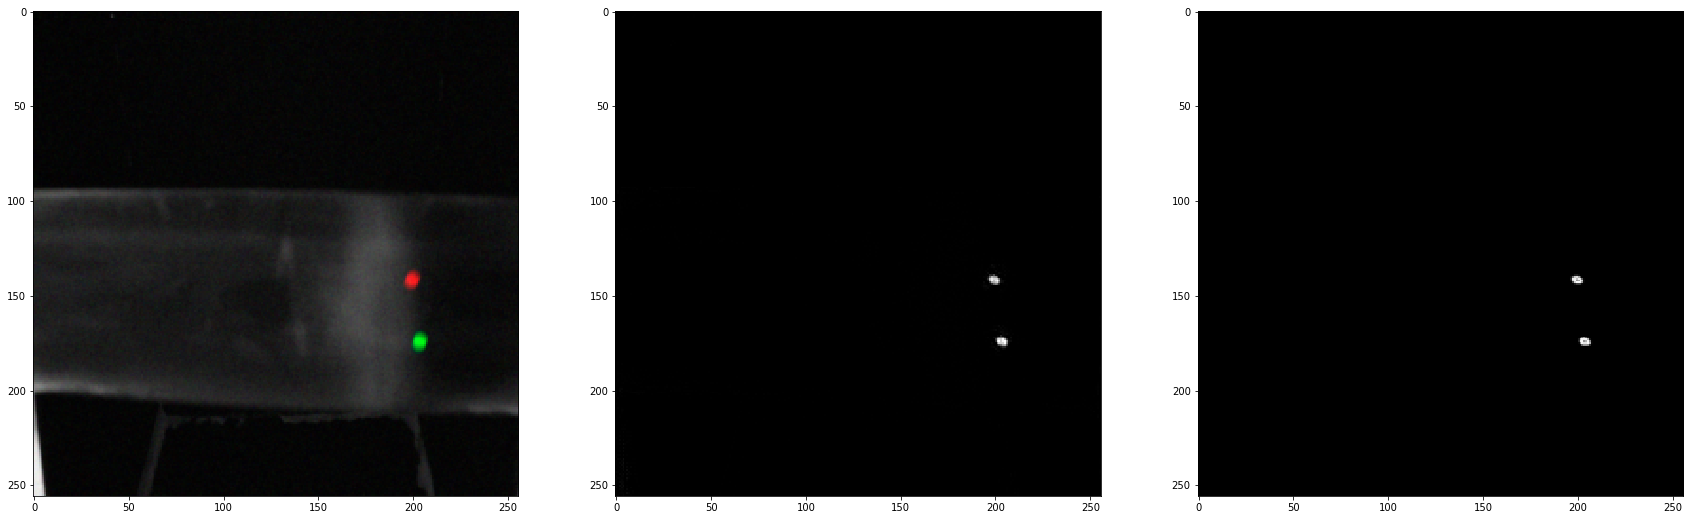

[0/10 (0%)]	


<Figure size 2880x2880 with 0 Axes>

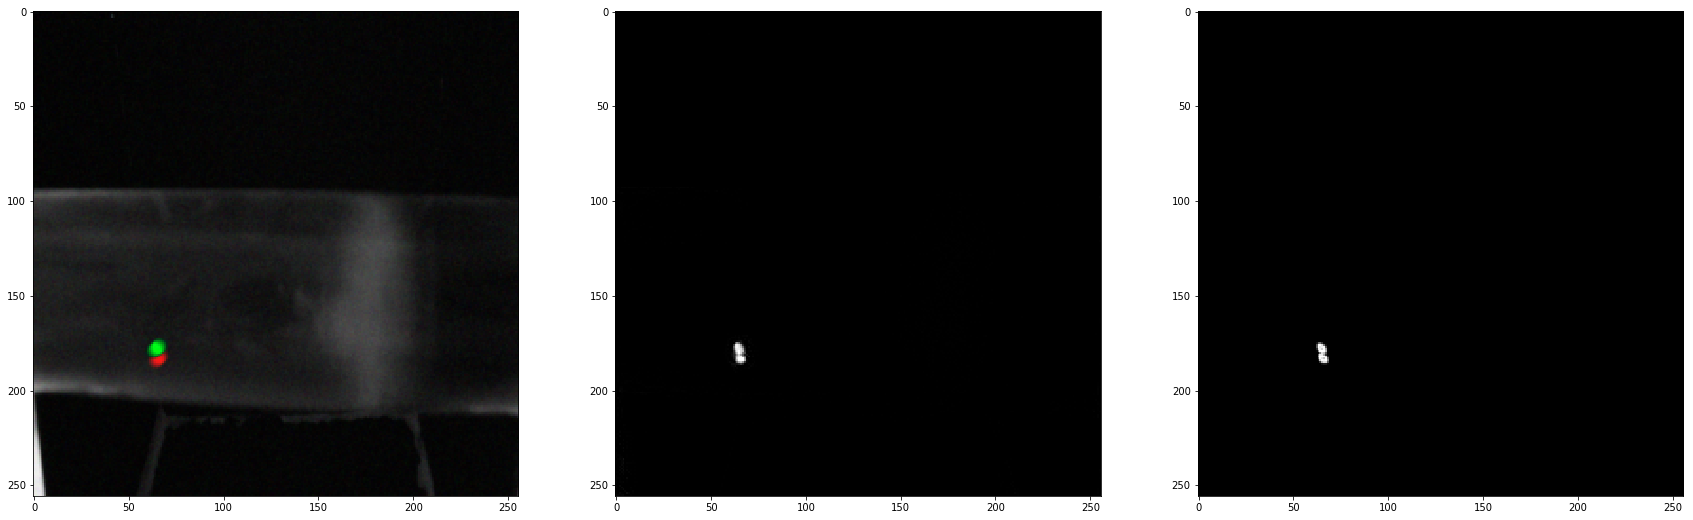

[1/10 (10%)]	


<Figure size 2880x2880 with 0 Axes>

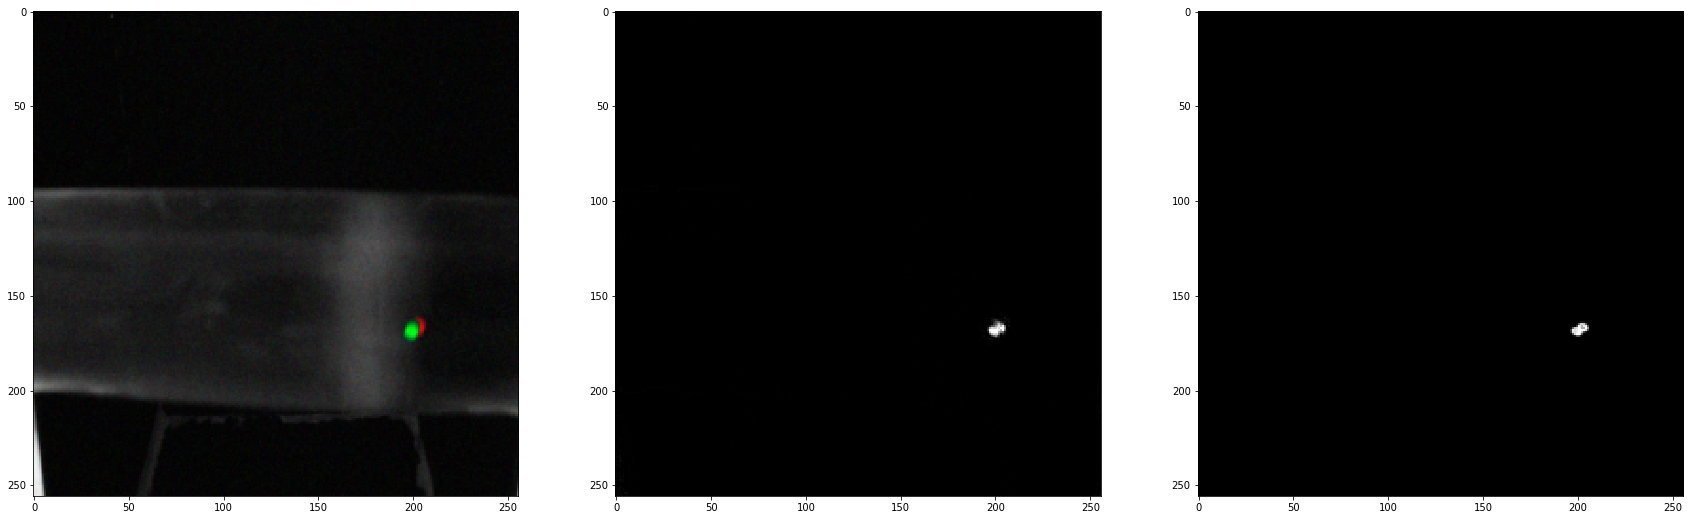

[2/10 (20%)]	


<Figure size 2880x2880 with 0 Axes>

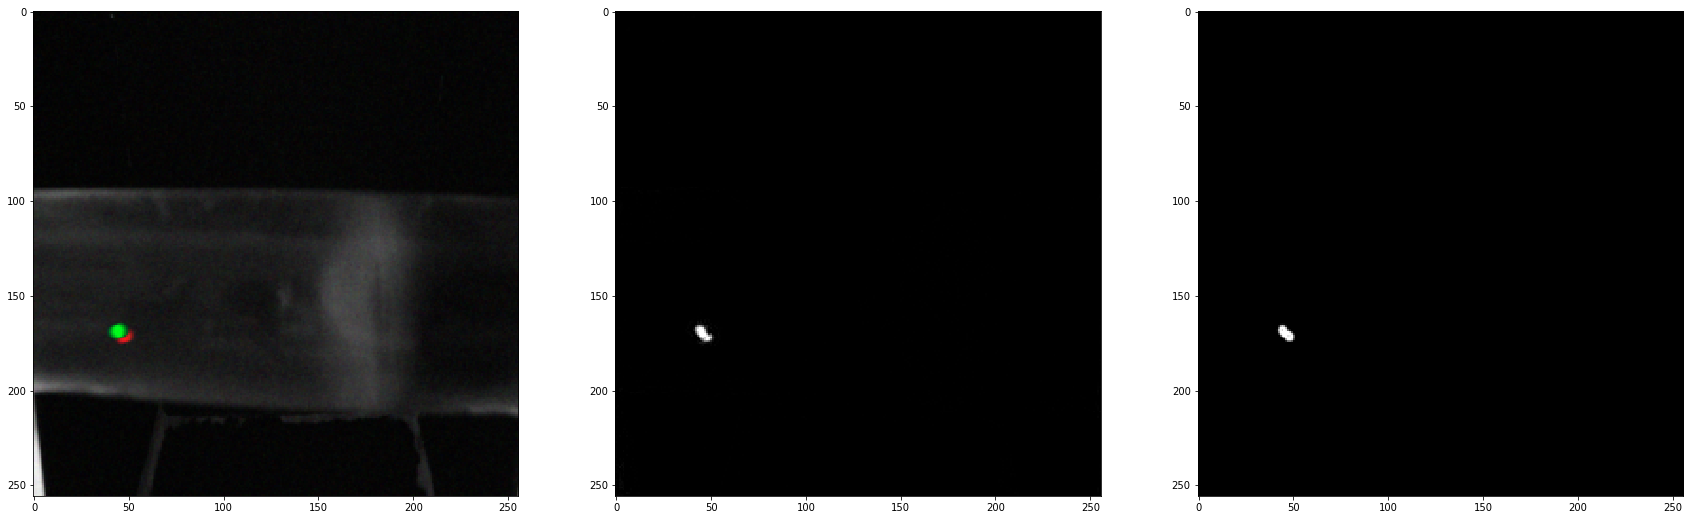

[3/10 (30%)]	


<Figure size 2880x2880 with 0 Axes>

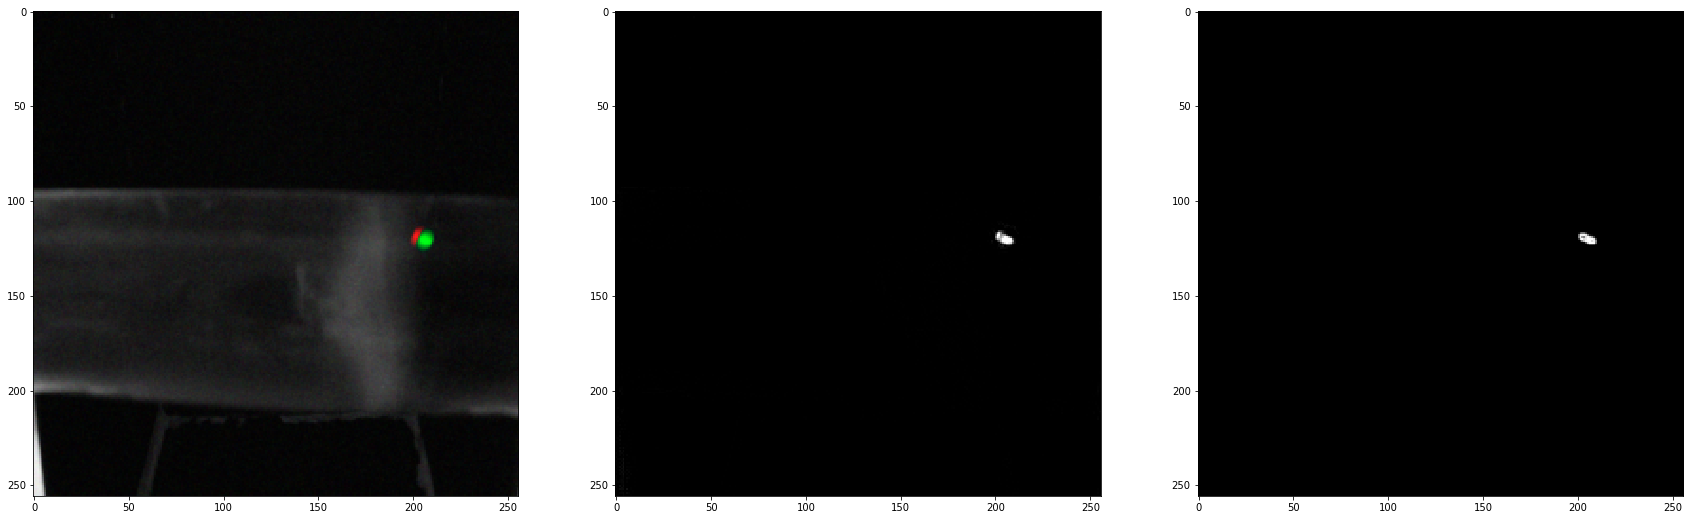

[4/10 (40%)]	


<Figure size 2880x2880 with 0 Axes>

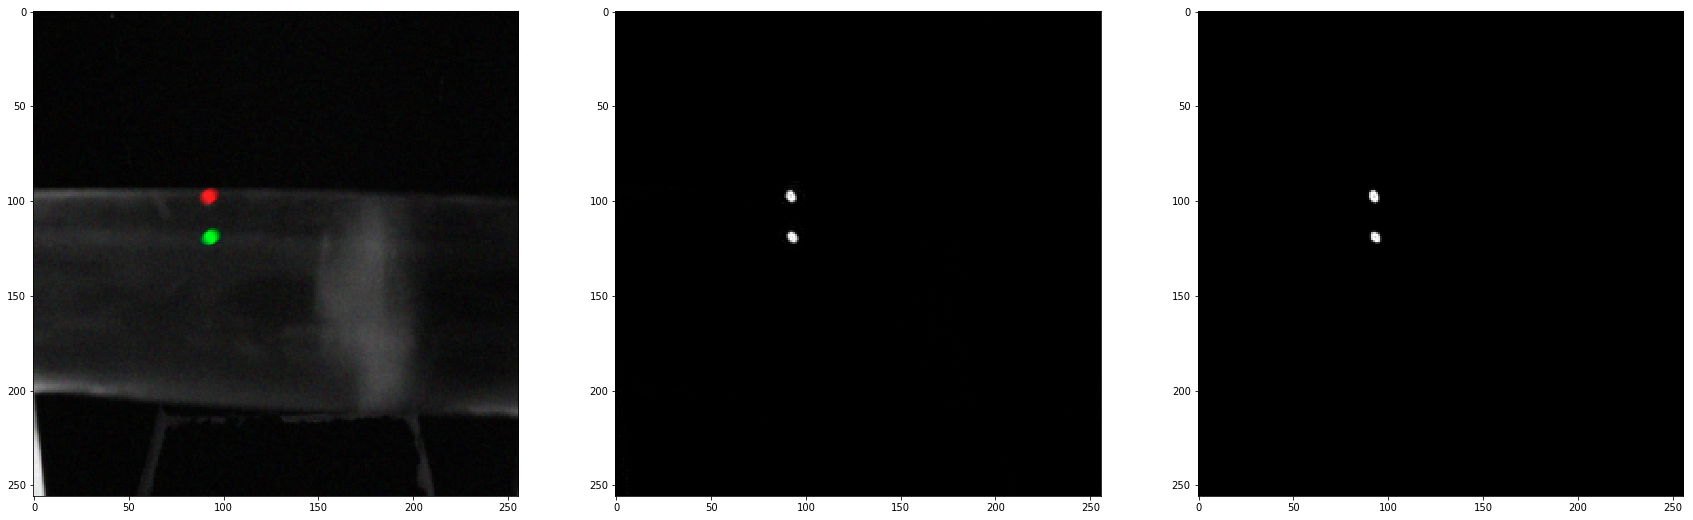

[5/10 (50%)]	


<Figure size 2880x2880 with 0 Axes>

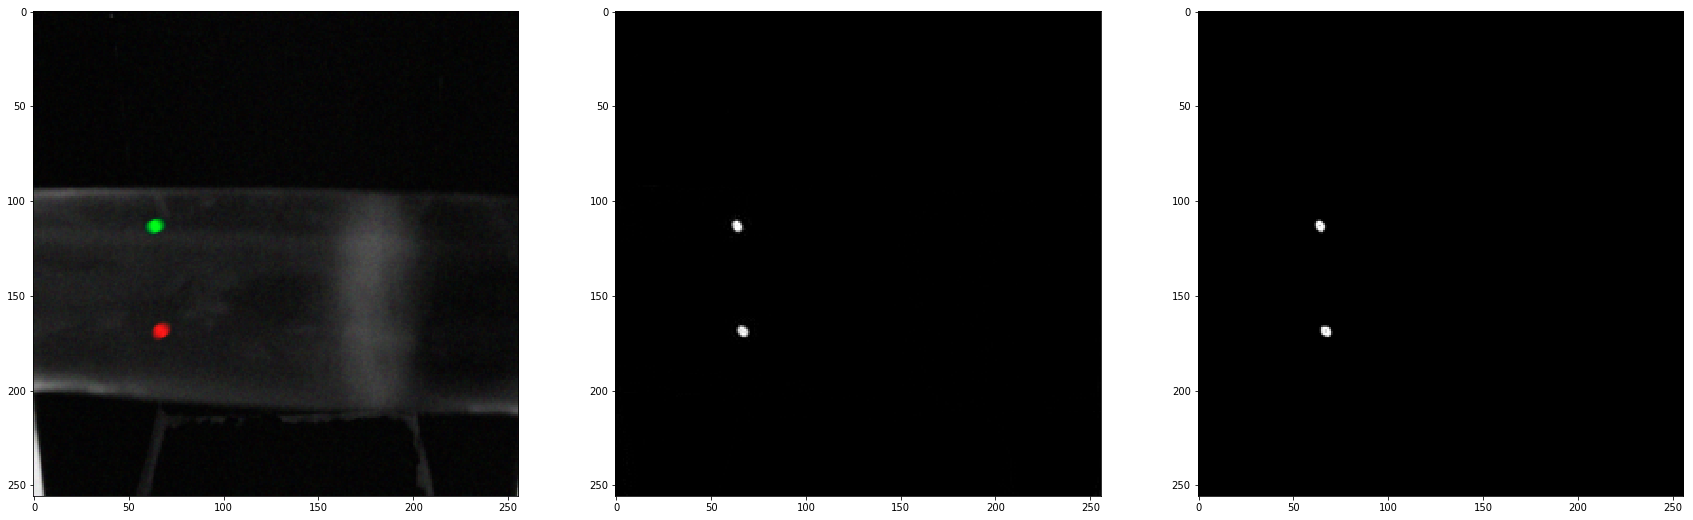

[6/10 (60%)]	


<Figure size 2880x2880 with 0 Axes>

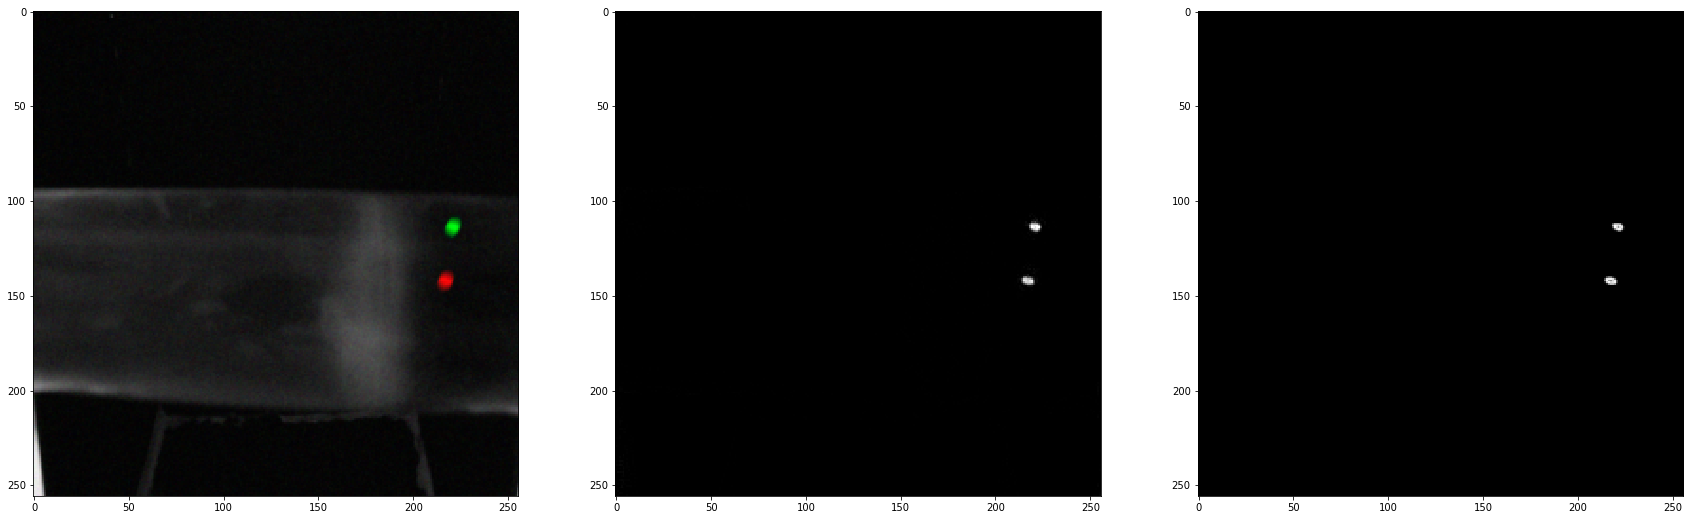

[7/10 (70%)]	


<Figure size 2880x2880 with 0 Axes>

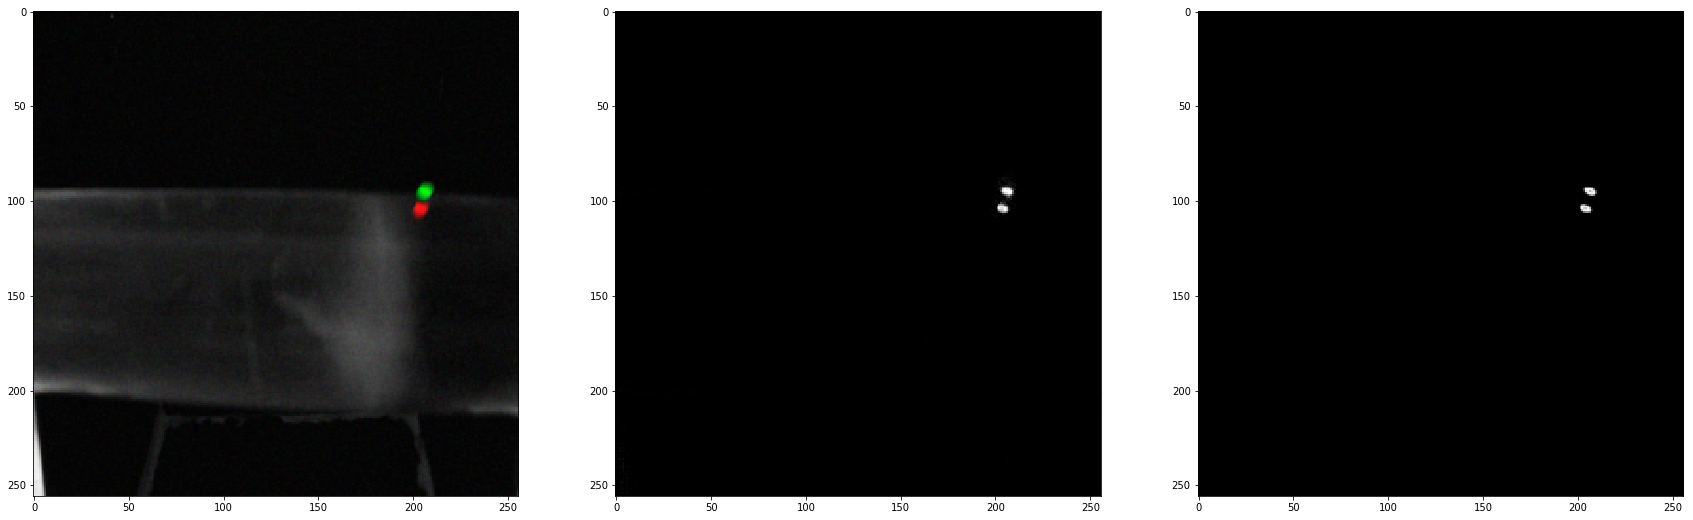

[8/10 (80%)]	


<Figure size 2880x2880 with 0 Axes>

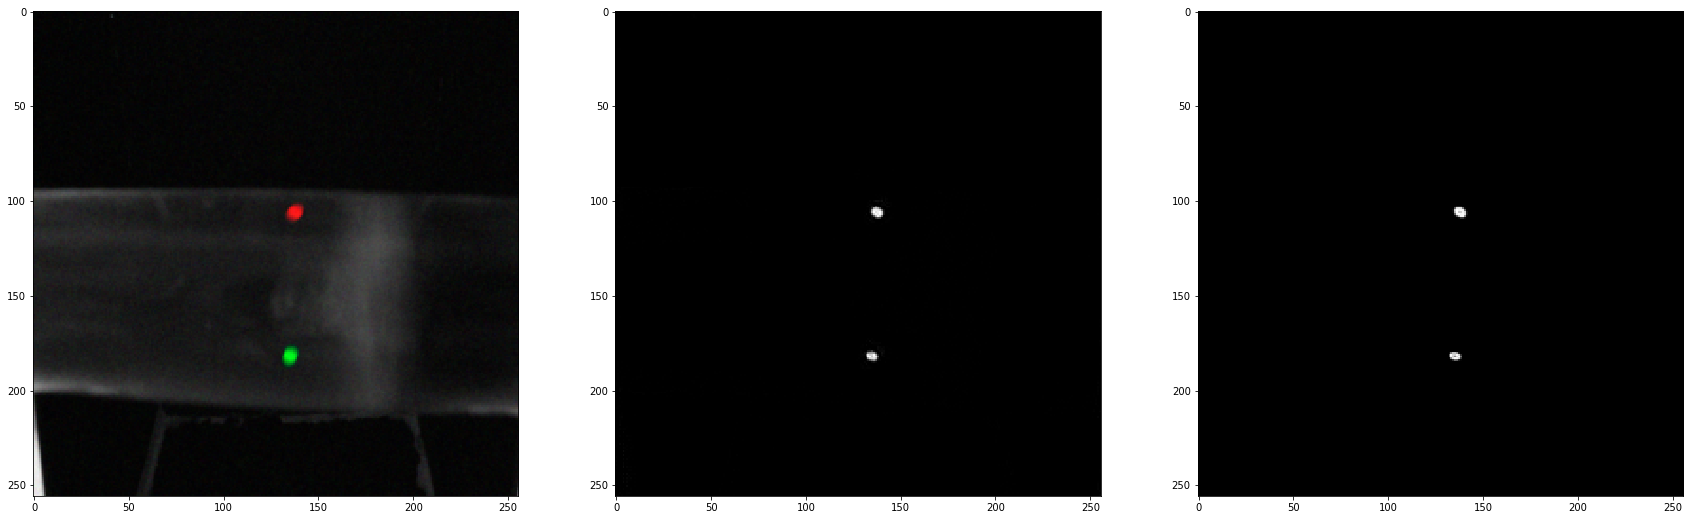

[9/10 (90%)]	

Validation set: Average loss: 2.8541737265186384e-05

Average Validation Accuracy: -2.8541737265186384e-05


In [0]:
predict(load='checkpoints/DT/weights1.pth',
        n_channels = 3,
        n_classes = 1,
        dir_pred = 'Datasets/Images/SenDF/Real/',
        dir_gt = 'Datasets/Images/SenDF/GT_DT/',
        evaluation="MSE", 
        out=None)

# Test predictions for top model

Model loaded from checkpoints/Border/K-Folds/weights1.pth


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


<Figure size 1440x1440 with 0 Axes>

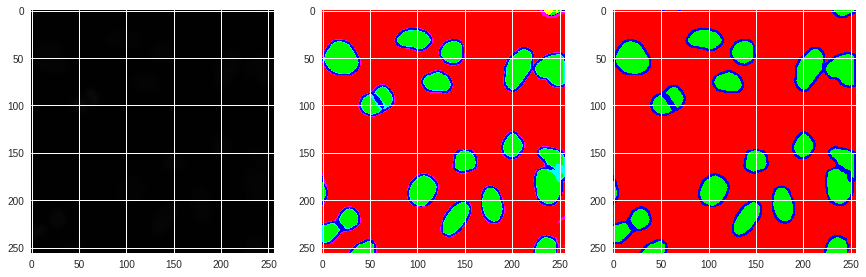

[0/10 (0%)]	


<Figure size 1440x1440 with 0 Axes>

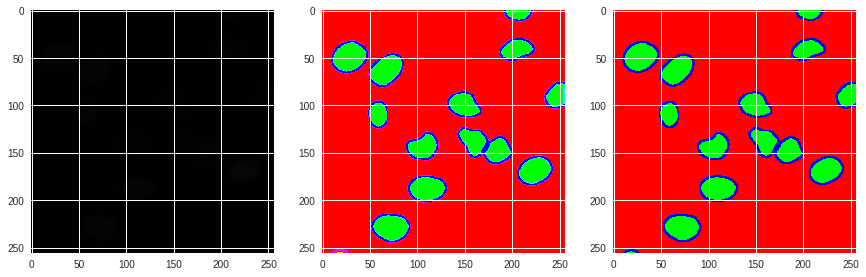

[1/10 (10%)]	


<Figure size 1440x1440 with 0 Axes>

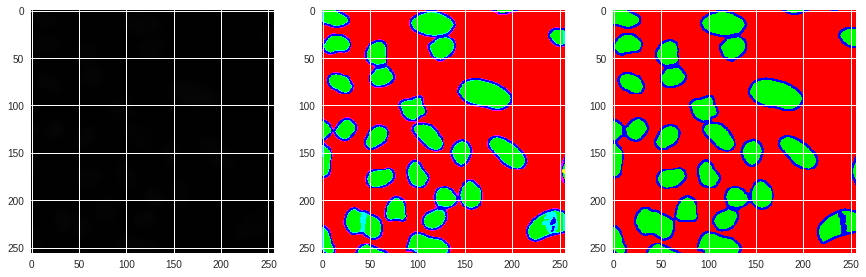

[2/10 (20%)]	


<Figure size 1440x1440 with 0 Axes>

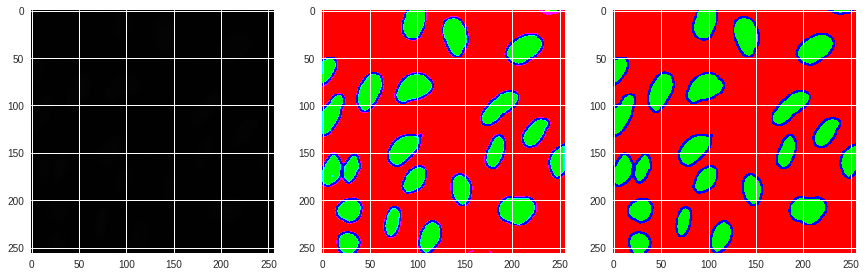

[3/10 (30%)]	


<Figure size 1440x1440 with 0 Axes>

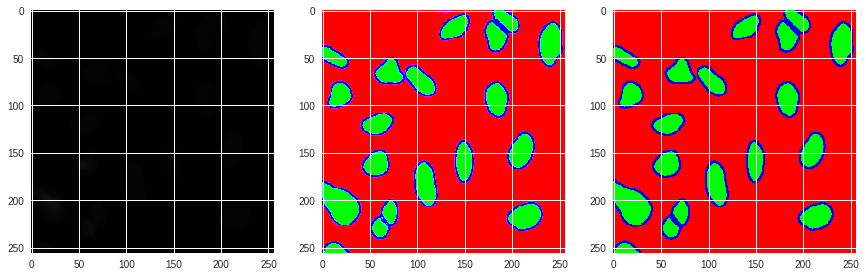

[4/10 (40%)]	


<Figure size 1440x1440 with 0 Axes>

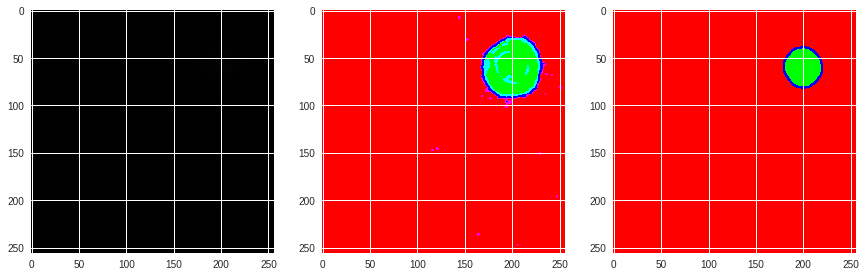

[5/10 (50%)]	


<Figure size 1440x1440 with 0 Axes>

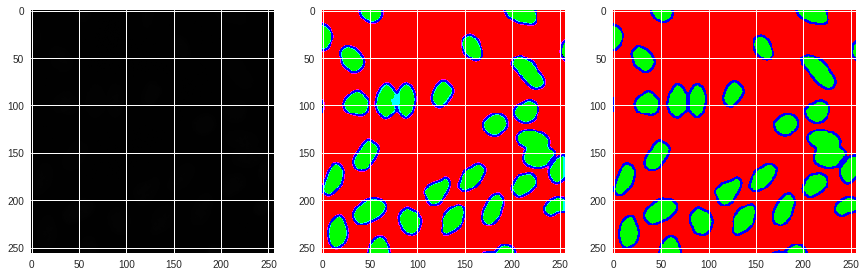

[6/10 (60%)]	


<Figure size 1440x1440 with 0 Axes>

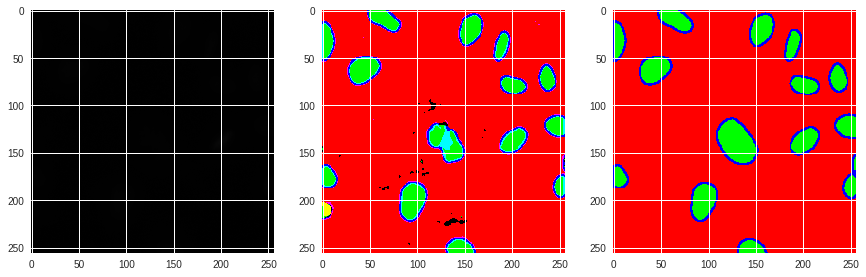

[7/10 (70%)]	


<Figure size 1440x1440 with 0 Axes>

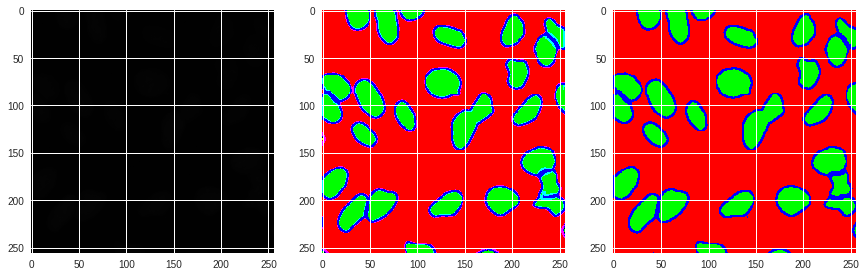

[8/10 (80%)]	


<Figure size 1440x1440 with 0 Axes>

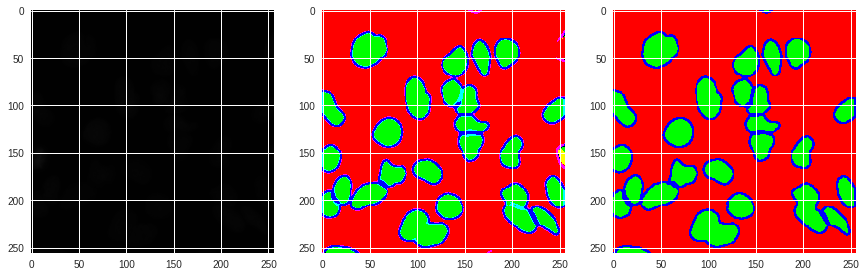

[9/10 (90%)]	

Validation set: Average loss: 21793.6546875

Average Validation Accuracy: -21793.6546875


In [0]:
predict(load='checkpoints/Border/K-Folds/weights1.pth',
        n_channels = 1,
        n_classes = 3,
        dir_pred = 'data/Original/',
        dir_pred_2 = None,
        dir_gt = 'data/Border/',
        evaluation="MSE", 
        out=None)